In [3]:
from scipy.spatial import distance_matrix
import numpy as np

def gammaidx(X, k):
    n = X.shape[0]  # Number of data points
    D = distance_matrix(X, X)  # Compute the distance matrix
    
    # Initialize the γ-index array
    y = np.zeros(n)
    
    # Iterate over each data point
    for i in range(n):
        # Find the indices of the k-nearest neighbors (excluding the point itself)
        neighbor_ids = np.argsort(D[i])[1:k+1]  # Exclude self in nearest neighbors
        
        # Retrieve the original points for the k-nearest neighbors
        neighbors = X[neighbor_ids]
        
        # Project the neighbors by subtracting the mean of the neighbors
        mean_neighbors = neighbors.mean(axis=0)
        projected_neighbors = neighbors - mean_neighbors
        
        # Compute the mean Euclidean distance from the original point to its projected neighbors
        original_point = X[i] - mean_neighbors  # Also project the original point
        distances = np.linalg.norm(projected_neighbors - original_point, axis=1)
        y[i] = distances.mean()
    
    return y

In [4]:
##add outliers according to the contamination rate
def sample_outliers(n_samples, lower=-4, upper=4):
    return np.random.uniform(lower, upper, (n_samples, 2))
    
def add_outliers(X, contamination_rate):
    n_outliers = int(len(X) * contamination_rate / 100)
    outliers = sample_outliers(n_outliers, lower=-4, upper=4)  
    combined_data = np.vstack((X, outliers))  
    labels = np.hstack((-1 * np.ones(len(X)), np.ones(n_outliers))) 
    return combined_data, labels

In [5]:
def distance_to_mean(X):
    mean = np.mean(X, axis=0)
    distances = np.linalg.norm(X - mean, axis=1)
    return distances

In [6]:
def calculate_auc(labels, scores):
    sorted_indices = np.argsort(scores)
    sorted_labels = labels[sorted_indices]
    sorted_scores = scores[sorted_indices]

    tpr = np.cumsum(sorted_labels == 1) / (sorted_labels == 1).sum()
    fpr = np.cumsum(sorted_labels == -1) / (sorted_labels == -1).sum()

    tpr = np.concatenate(([0], tpr, [1]))
    fpr = np.concatenate(([0], fpr, [1]))

    auc = np.trapz(tpr, fpr)
    return auc


In [7]:
## load data
import numpy as np
import pandas as pd
data_banana = np.load('/Users/yanqingluo/Desktop/LabML/problem_set1/data/banana.npz')

X_banana = data_banana['data']
X_banana = np.array(X_banana)
y_banana = data_banana['label']
y_banana = np.array(y_banana)
X_banana = X_banana.T
y_banana = y_banana.reshape(-1)
print("Shape of X_banana:", X_banana.shape)
print("Shape of y_banana:", y_banana.shape)
df = pd.DataFrame(X_banana, columns=['feature_1', 'feature_2'])
df['label'] = y_banana
df.head()

Shape of X_banana: (5300, 2)
Shape of y_banana: (5300,)


,feature_1,feature_2,label
0,-3.089839,-0.831686,-1.0
1,-2.980834,-0.159575,-1.0
2,-2.836057,-0.177081,-1.0
3,-2.767849,0.096217,-1.0
4,-2.600350,0.216772,-1.0


In [8]:
contamination_rates = [1, 10, 50, 100] 
repetitions = 100  

results = {}
for rate in contamination_rates:
    auc_scores_k3 = []
    auc_scores_k10 = []
    auc_scores_dtm = []

    for _ in range(repetitions):
        data_with_outliers, labels = add_outliers(X_banana, rate)
  
        scores_k3 = gammaidx(data_with_outliers, k=3)
        scores_k10 = gammaidx(data_with_outliers, k=10)
        scores_dtm = distance_to_mean(data_with_outliers)
        
        auc_k3 = calculate_auc(labels, scores_k3)
        auc_k10 = calculate_auc(labels, scores_k10)
        auc_dtm = calculate_auc(labels, scores_dtm)
        
        auc_scores_k3.append(auc_k3)
        auc_scores_k10.append(auc_k10)
        auc_scores_dtm.append(auc_dtm)

    results[rate] = {
        'gamma_k3': auc_scores_k3,
        'gamma_k10': auc_scores_k10,
        'dist_to_mean': auc_scores_dtm
    }

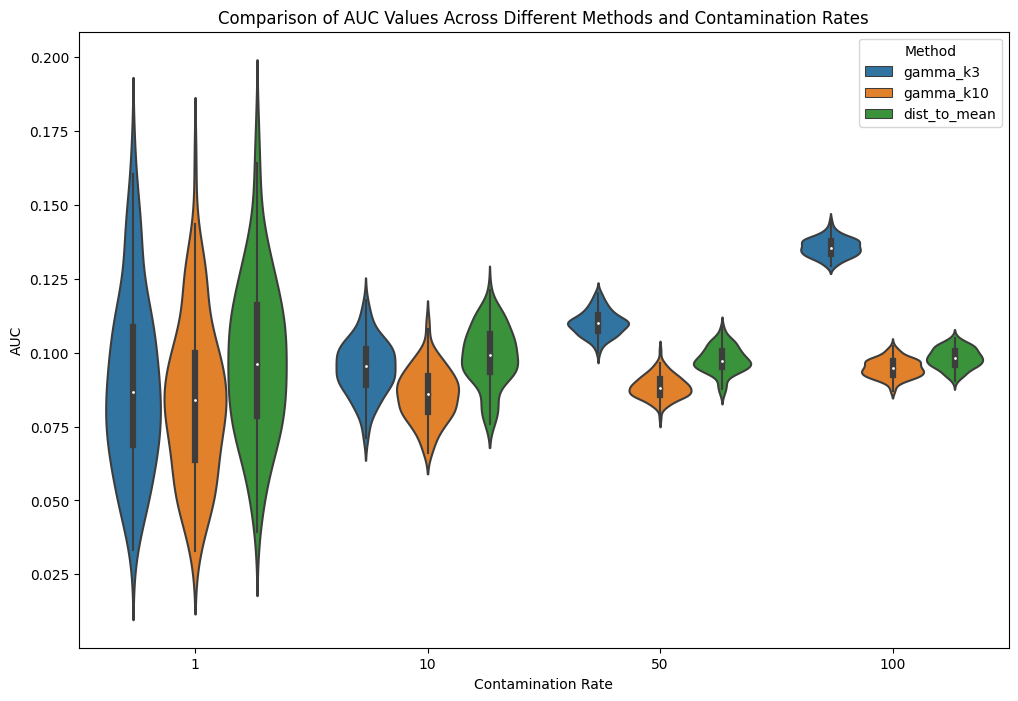

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Create a DataFrame from the nested dictionary
data = []
for rate, methods in results.items():
    for method, scores in methods.items():
        for score in scores:
            data.append({
                'Contamination Rate': rate,
                'Method': method,
                'AUC': score
            })

df_data = pd.DataFrame(data)

plt.figure(figsize=(12, 8))
sns.violinplot(data=df_data, x='Contamination Rate', y='AUC', hue='Method')
plt.title('Comparison of AUC Values Across Different Methods and Contamination Rates')
plt.legend(title='Method')
plt.show()

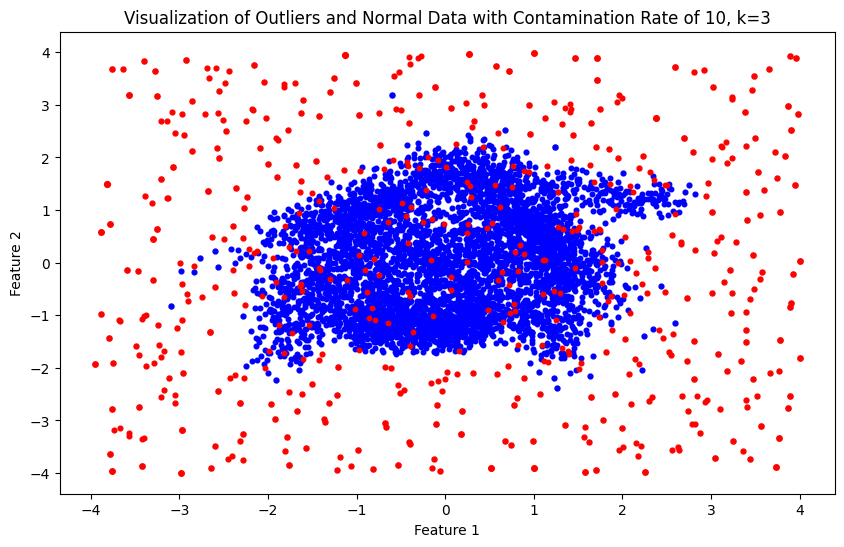

In [10]:
selected_rate = 10
data_with_outliers, labels = add_outliers(X_banana, selected_rate)
scores = gammaidx(data_with_outliers, k=3)  # Example using gamma index with k=3

# Visualization
plt.figure(figsize=(10, 6))
for i in range(len(data_with_outliers)):
    color = 'red' if labels[i] == 1 else 'blue'
    plt.scatter(data_with_outliers[i, 0], data_with_outliers[i, 1], color=color, s=np.exp(scores[i]) * 10)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Visualization of Outliers and Normal Data with Contamination Rate of 10, k=3')
plt.show()

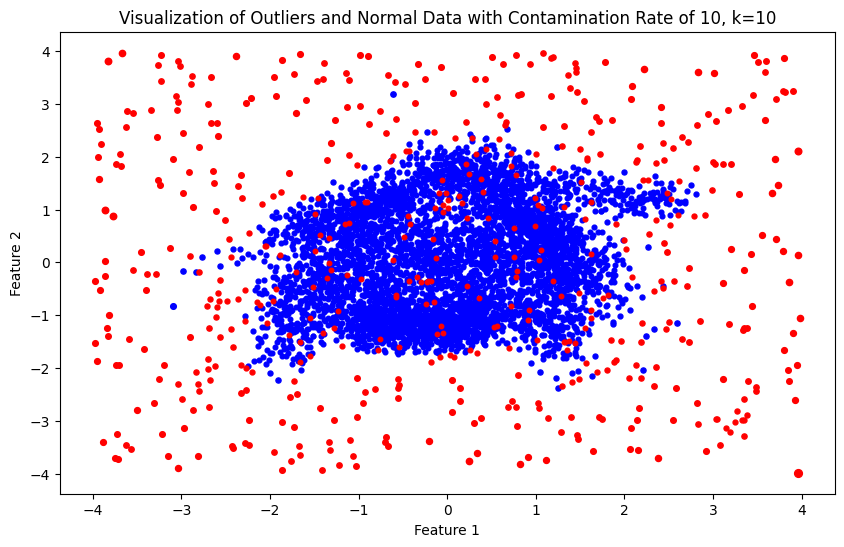

In [11]:
selected_rate = 10
data_with_outliers, labels = add_outliers(X_banana, selected_rate)
scores = gammaidx(data_with_outliers, k=10)

# Visualization
plt.figure(figsize=(10, 6))
for i in range(len(data_with_outliers)):
    color = 'red' if labels[i] == 1 else 'blue'
    plt.scatter(data_with_outliers[i, 0], data_with_outliers[i, 1], color=color, s=np.exp(scores[i]) * 10)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Visualization of Outliers and Normal Data with Contamination Rate of 10, k=10')
plt.show()

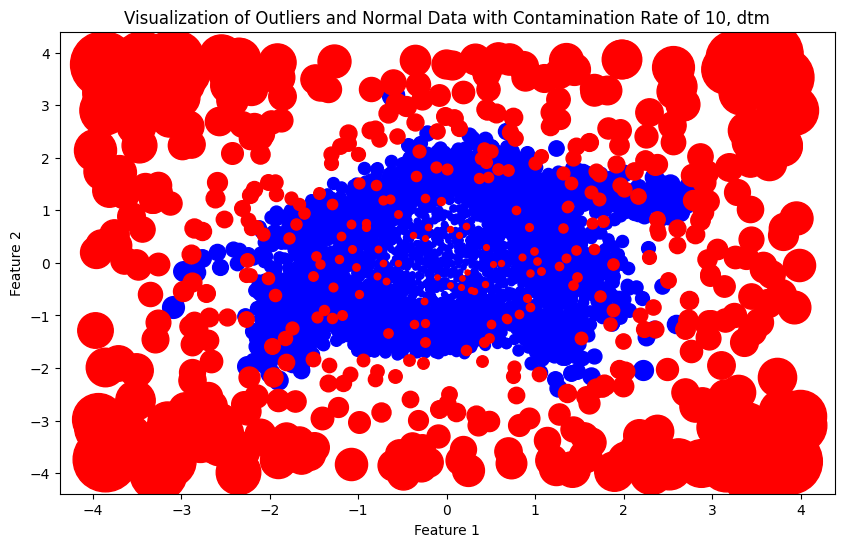

In [12]:
selected_rate = 10
data_with_outliers, labels = add_outliers(X_banana, selected_rate)
scores = distance_to_mean(data_with_outliers)

# Visualization
plt.figure(figsize=(10, 6))
for i in range(len(data_with_outliers)):
    color = 'red' if labels[i] == 1 else 'blue'
    plt.scatter(data_with_outliers[i, 0], data_with_outliers[i, 1], color=color, s=np.exp(scores[i]) * 10)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Visualization of Outliers and Normal Data with Contamination Rate of 10, dtm')
plt.show()